In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
import keras
import time
import cv2
import os

from keras import preprocessing
from keras import regularizers
from keras import activations
from keras import optimizers
from keras import callbacks
from keras import layers
from keras import losses
from keras import models

In [5]:
data_base_path = 'E:/Data/Video_Frame_Interpolation/processed/low_motion'
data_creation_time = '1681942749'
model_base_path = 'E:/OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie/Programming/Labs/Frame_booster/models'
width, height = 224, 128

In [6]:
def load_data(base_path, creation_time, width, height):
    with open(os.path.join(base_path, f'x_train_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_train = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_train_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_train = pickle.load(file)
        
    with open(os.path.join(base_path, f'x_test_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_test = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_test_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_test = pickle.load(file)
        
    with open(os.path.join(base_path, f'x_valid_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        x_valid = pickle.load(file)
        
    with open(os.path.join(base_path, f'y_valid_{height}x{width}_{creation_time}.pickle'), 'rb') as file:
        y_valid = pickle.load(file)
        
    return (np.array(x_train)/255.0).astype('float32'), (np.array(x_test)/255.0).astype('float32'), (np.array(x_valid)/255.0).astype('float32'), (np.array(y_train)/255.0).astype('float32'), (np.array(y_test)/255.0).astype('float32'), (np.array(y_valid)/255.0).astype('float32')

In [7]:
x_train, x_test, x_valid, y_train, y_test, y_valid = load_data(
    data_base_path,
    data_creation_time,
    width, 
    height
)

## Model

In [8]:
epochs = 20
batch_size = 16

In [17]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [18]:
input_1 = layers.Input(shape=(height, width, 3,))
input_2 = layers.Input(shape=(height, width, 3,))

merged_1 = layers.Add()([input_1, input_2])
cnn1 = layers.Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same')(merged_1)
cnn2 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(cnn1)

cnn1_1 = layers.Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same')(input_1)
cnn2_1 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(cnn1_1)

cnn1_2 = layers.Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same')(input_2)
cnn2_2 = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(cnn1_2)

merged_2 = layers.Add()([cnn2, cnn2_1, cnn2_2])

cnn_m_1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merged_2)
cnn_up_1 = layers.UpSampling2D((2, 2), interpolation='bilinear')(cnn_m_1)

cnn_m_2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(cnn_up_1)
cnn_up_2 = layers.UpSampling2D((2, 2), interpolation='bilinear')(cnn_m_2)

outputs = layers.Conv2D(3, (3, 3), padding='same')(cnn_up_2)

model = keras.Model(inputs=[input_1, input_2], outputs=[outputs])

model.compile(
    loss = ssim_loss,
    optimizer = optimizers.Nadam(0.001),
    metrics = [ssim_loss, 'mae', 'mse']
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 128, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 add_4 (Add)                    (None, 128, 224, 3)  0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [27]:
start = 0
end = 500

history = model.fit(
    x = [x_train[start:end][:, 0, :, :], x_train[start:end][:, 1, :, :]],
    y = y_train[start:end],
    epochs=epochs,
    batch_size=batch_size,
    validation_data = ([x_valid[0:50][:, 0, :, :], x_valid[0:50][:, 1, :, :]], y_valid[0:50])
)

Epoch 1/20
32/32 [==============================] - 4s 119ms/step - loss: 0.2851 - mae: 0.0709 - mse: 0.0117 - val_loss: 0.2793 - val_mae: 0.0787 - val_mse: 0.0124
Epoch 2/20
32/32 [==============================] - 4s 116ms/step - loss: 0.2908 - mae: 0.0806 - mse: 0.0136 - val_loss: 0.2867 - val_mae: 0.0971 - val_mse: 0.0177
Epoch 3/20
32/32 [==============================] - 4s 117ms/step - loss: 0.2868 - mae: 0.0752 - mse: 0.0125 - val_loss: 0.2837 - val_mae: 0.0713 - val_mse: 0.0116
Epoch 4/20
32/32 [==============================] - 4s 117ms/step - loss: 0.2857 - mae: 0.0741 - mse: 0.0122 - val_loss: 0.2743 - val_mae: 0.0695 - val_mse: 0.0110
Epoch 5/20
32/32 [==============================] - 4s 117ms/step - loss: 0.2831 - mae: 0.0682 - mse: 0.0110 - val_loss: 0.2789 - val_mae: 0.0685 - val_mse: 0.0106
Epoch 6/20
32/32 [==============================] - 4s 116ms/step - loss: 0.2835 - mae: 0.0717 - mse: 0.0118 - val_loss: 0.3075 - val_mae: 0.1112 - val_mse: 0.0226
Epoch 7/20
32/32

## Training evaluation

In [28]:
predictions = model.predict([x_test[0:10][:, 0, :, :], x_test[0:10][0:10][:, 1, :, :]])

1/1 [==============================] - 0s 105ms/step


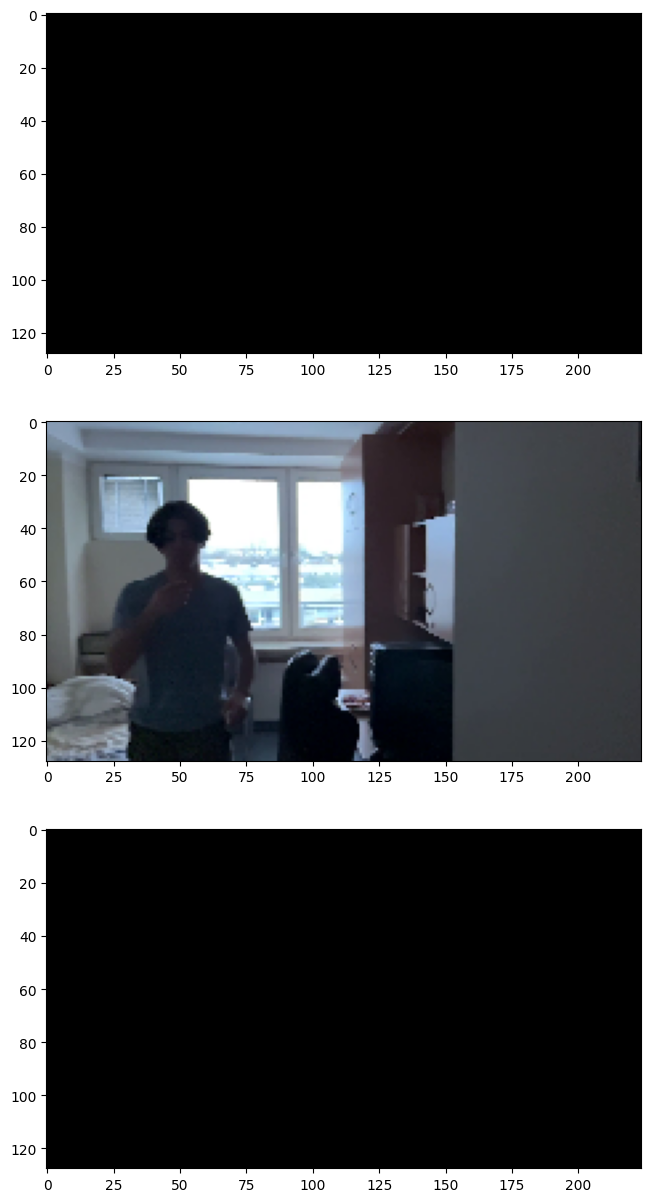

In [29]:
f, ax = plt.subplots(3, 1)
f.set_size_inches(10, 15)

index = 0
ax[0].imshow(predictions[index])
ax[1].imshow(y_test[index])
ax[2].imshow(cv2.absdiff(predictions[index], y_test[index]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


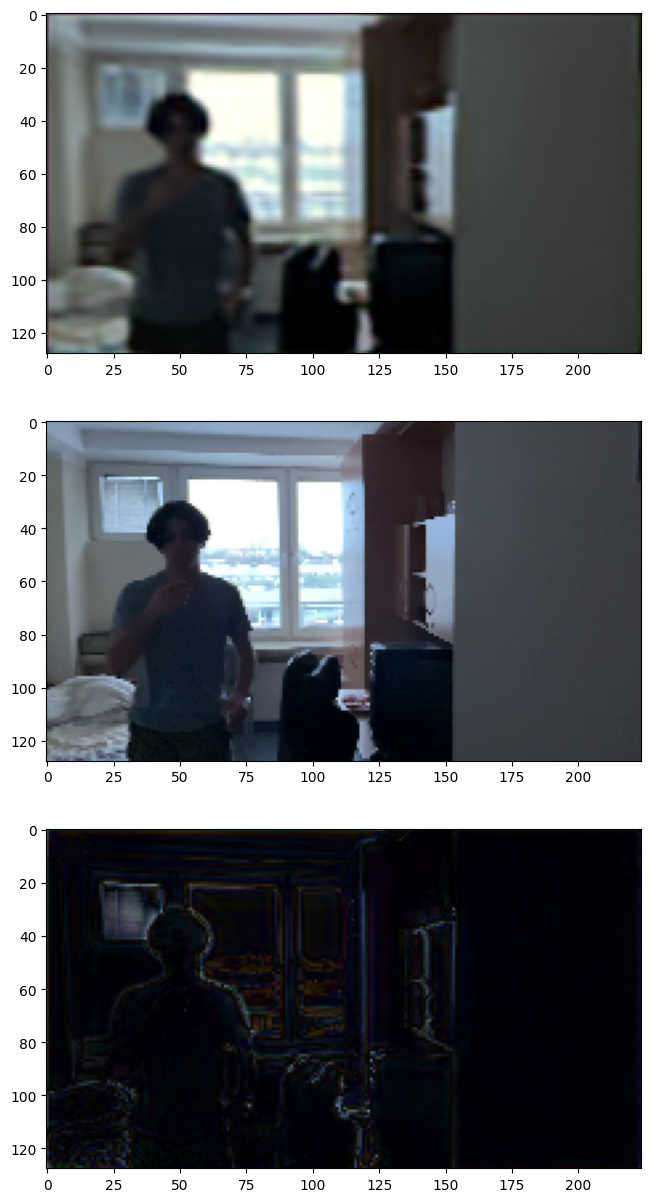

In [21]:
f, ax = plt.subplots(3, 1)
f.set_size_inches(10, 15)

index = 0
ax[0].imshow(predictions[index])
ax[1].imshow(y_test[index])
ax[2].imshow(cv2.absdiff(predictions[index], y_test[index]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


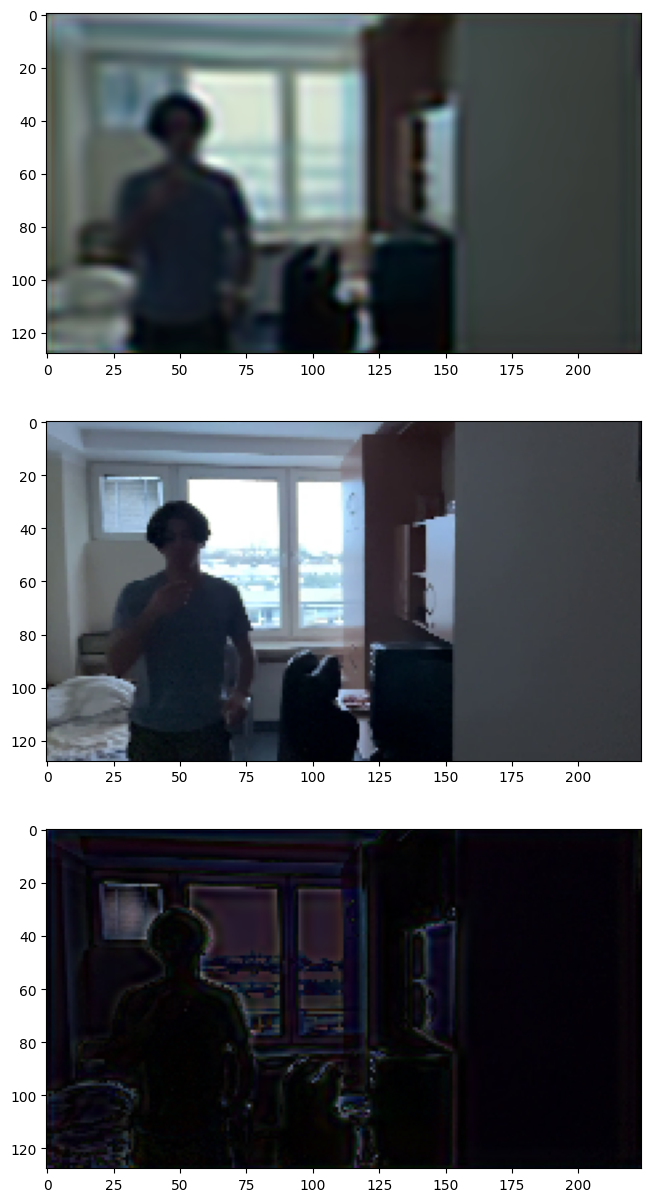

In [16]:
f, ax = plt.subplots(3, 1)
f.set_size_inches(10, 15)

index = 0
ax[0].imshow(predictions[index])
ax[1].imshow(y_test[index])
ax[2].imshow(cv2.absdiff(predictions[index], y_test[index]))